In [1]:
# Renko Chart Analysis with Stochastic Oscillator

#This notebook builds a Renko chart from historical OHLC data, calculates technical indicators, and generates buy/sell signals based on Stochastic crossovers.
    

In [2]:
## 1. Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
## 2. Configuration Parameters
# Ticker and date range
ticker = 'SPY'
start_date = '2023-01-01'
end_date = '2025-12-31'

# Renko brick size
brick_size = 5  # Adjust as needed

In [4]:
## 3. Download OHLC Data from Yahoo Finance
# Download OHLC data from Yahoo Finance
df = yf.download(ticker, start=start_date, end=end_date)

# Flatten MultiIndex columns (fix for newer yfinance versions)
df.columns = df.columns.get_level_values(0)

# Keep only the essential columns
df = df[['Open', 'High', 'Low', 'Close']]

# Display first few rows
df.head()

/var/folders/2v/mkg1tcnj0dsgbn4wspnx8l0h0000gn/T/ipykernel_80585/3182336233.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close
Date,,,,
2022-01-03,450.541403,452.007595,448.223918,451.875153
2022-01-04,453.303545,454.022453,449.860384,451.723846
2022-01-05,451.354915,452.130576,442.955146,443.049744
2022-01-06,442.586199,445.357736,440.259217,442.633484
2022-01-07,442.643001,443.825400,439.521449,440.883575


In [5]:
## 4. Build Renko Bricks
# Convert Close prices to list
prices = df['Close'].values.flatten().tolist()

renko_data = []   # Stores price levels of each brick
directions = []   # 1 = up, -1 = down, 0 = neutral (first brick)

last_price = prices[0]
renko_data.append(last_price)
directions.append(0)

for price in prices:
    diff = price - last_price
    brick_moves = int(diff / brick_size)

    while brick_moves != 0:
        if brick_moves > 0:
            last_price += brick_size
            renko_data.append(last_price)
            directions.append(1)
            brick_moves -= 1
        elif brick_moves < 0:
            last_price -= brick_size
            renko_data.append(last_price)
            directions.append(-1)
            brick_moves += 1

print(f"Total Renko bricks: {len(renko_data)}")

Total Renko bricks: 289


In [6]:
## 5. Calculate X and Y Positions for Bricks
x_positions = [0]
y_positions = [renko_data[0]]

for i in range(1, len(renko_data)):
    prev_x = x_positions[-1]
    prev_y = y_positions[-1]
    
    if renko_data[i] > renko_data[i-1]:
        x_positions.append(prev_x + 1)
        y_positions.append(prev_y + brick_size)
    else:
        x_positions.append(prev_x + 1)
        y_positions.append(prev_y - brick_size)

In [7]:
## 6. Create Renko DataFrame with Indicators
# Create DataFrame for Renko data
renko_df = pd.DataFrame({
    'X': x_positions,
    'Y': y_positions,
    'Price': renko_data,
    'Direction': directions
})

# Calculate 20-period Moving Average
renko_df['MA20'] = renko_df['Price'].rolling(window=20).mean()
ma20 = renko_df['MA20'].tolist()

# Calculate Stochastic Oscillator (10, 3, 3)
k_period = 10
d_period = 3
smooth_k = 3

renko_df['Lowest'] = renko_df['Price'].rolling(window=k_period).min()
renko_df['Highest'] = renko_df['Price'].rolling(window=k_period).max()
renko_df['%K'] = 100 * (renko_df['Price'] - renko_df['Lowest']) / (renko_df['Highest'] - renko_df['Lowest'])
renko_df['%K'] = renko_df['%K'].rolling(window=smooth_k).mean()
renko_df['%D_Smoothed'] = renko_df['%K'].rolling(window=d_period).mean()

renko_df.head(15)

,X,Y,Price,Direction,MA20,Lowest,Highest,%K,%D_Smoothed
0,0,451.875153,451.875153,0,NaN,NaN,NaN,NaN,NaN
1,1,446.875153,446.875153,-1,NaN,NaN,NaN,NaN,NaN
2,2,441.875153,441.875153,-1,NaN,NaN,NaN,NaN,NaN
3,3,436.875153,436.875153,-1,NaN,NaN,NaN,NaN,NaN
4,4,431.875153,431.875153,-1,NaN,NaN,NaN,NaN,NaN
5,5,426.875153,426.875153,-1,NaN,NaN,NaN,NaN,NaN
6,6,421.875153,421.875153,-1,NaN,NaN,NaN,NaN,NaN
7,7,416.875153,416.875153,-1,NaN,NaN,NaN,NaN,NaN
8,8,411.875153,411.875153,-1,NaN,NaN,NaN,NaN,NaN
9,9,416.875153,416.875153,1,NaN,411.875153,451.875153,NaN,NaN


In [8]:
## 7. Generate Buy/Sell Signals Based on %K / %D Crossovers
# Create a column to store signals (1 = buy, -1 = sell, 0 = no action)
renko_df['Signal'] = 0

# Loop through the data to detect crossovers
for i in range(1, len(renko_df)):
    # Buy Signal: %K crosses above %D_Smoothed
    if (renko_df.loc[i - 1, '%K'] < renko_df.loc[i - 1, '%D_Smoothed']) and \
       (renko_df.loc[i, '%K'] > renko_df.loc[i, '%D_Smoothed']):
        renko_df.loc[i, 'Signal'] = 1  # Buy

    # Sell Signal: %K crosses below %D_Smoothed
    elif (renko_df.loc[i - 1, '%K'] > renko_df.loc[i - 1, '%D_Smoothed']) and \
         (renko_df.loc[i, '%K'] < renko_df.loc[i, '%D_Smoothed']):
        renko_df.loc[i, 'Signal'] = -1  # Sell

# Display signal counts
print(f"Buy Signals: {(renko_df['Signal'] == 1).sum()}")
print(f"Sell Signals: {(renko_df['Signal'] == -1).sum()}")

Buy Signals: 17
Sell Signals: 21


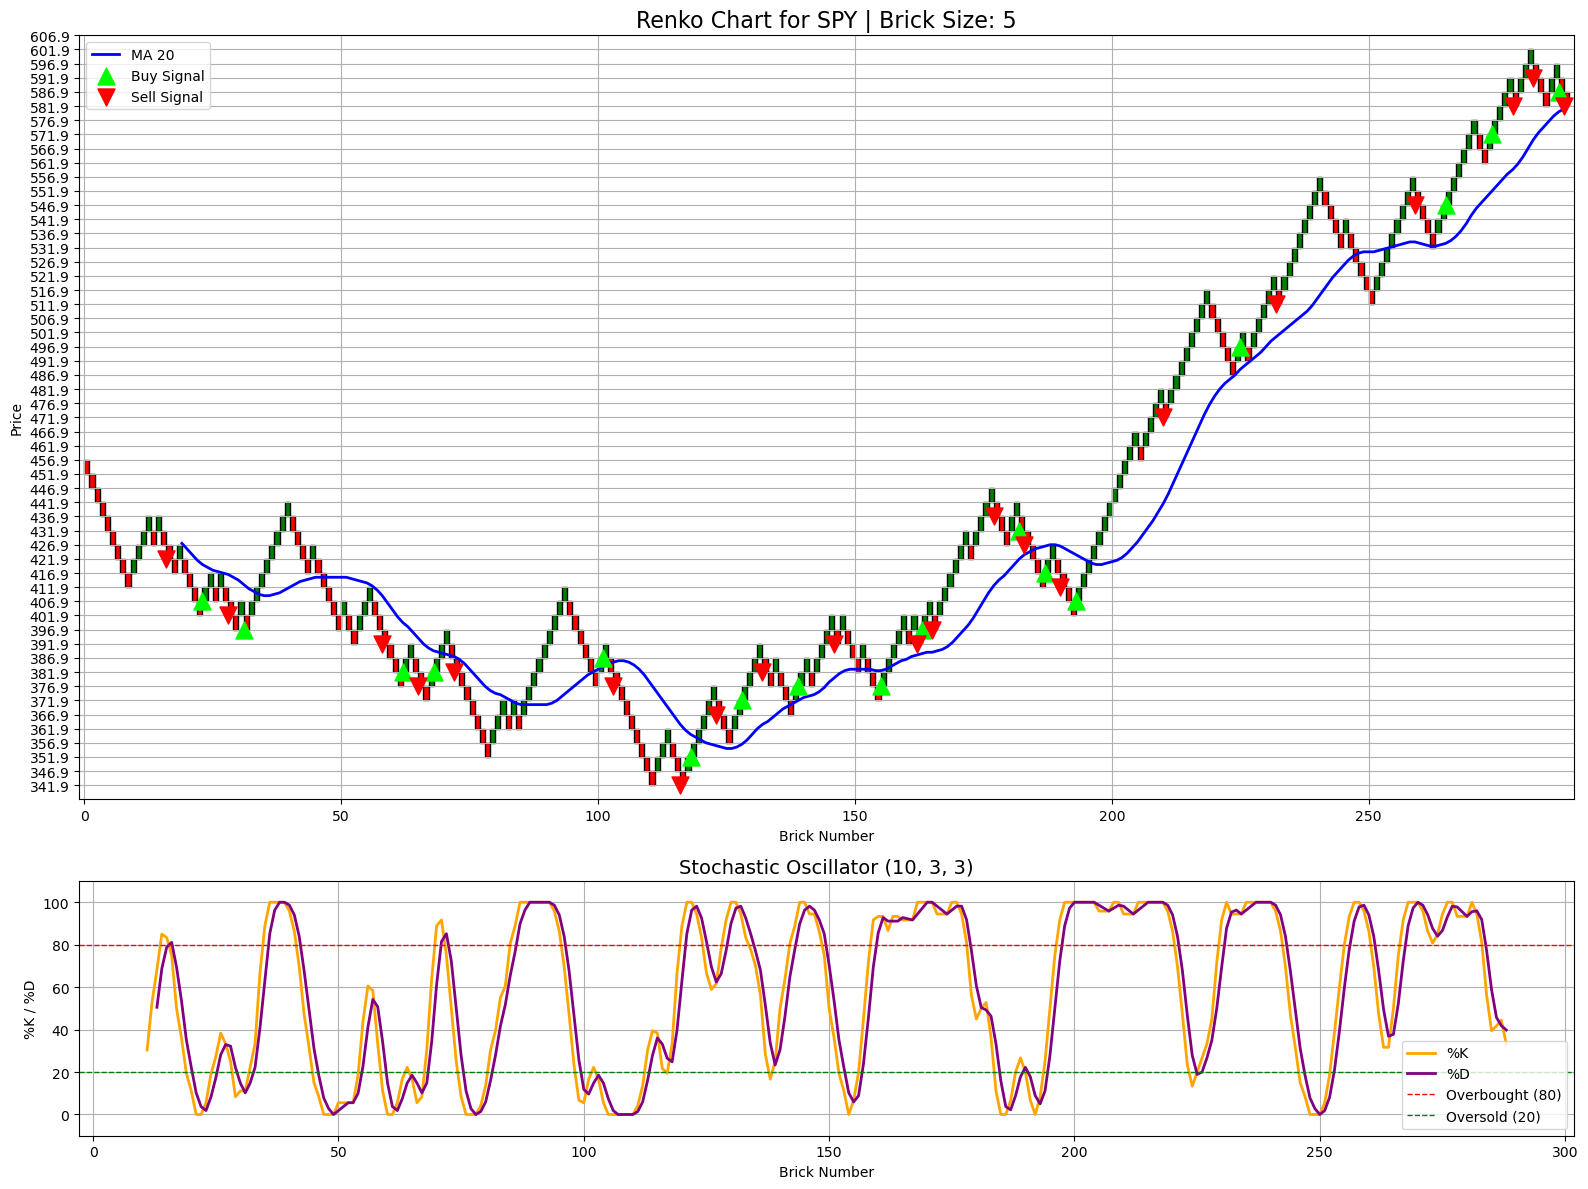

In [9]:
## 8. Plot Renko Chart with Stochastic Oscillator and Signals
# Setup the plot with two subplots: one for Renko, one for Stochastic
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1]})

# ------------------------------------
# Subplot 1: Renko Chart with 20-Period MA
# ------------------------------------

ax1.set_title(f"Renko Chart for {ticker} | Brick Size: {brick_size}", fontsize=16)
ax1.set_xlabel('Brick Number')
ax1.set_ylabel('Price')

# Plot each brick
for i in range(len(x_positions)):
    color = 'green' if directions[i] == 1 else 'red'
    rect = Rectangle(
        (x_positions[i], y_positions[i]), 1, brick_size,
        facecolor=color, edgecolor='black'
    )
    ax1.add_patch(rect)

# Plot 20-period Moving Average on Renko prices
ax1.plot(
    x_positions,
    ma20,
    color='blue',
    linewidth=2,
    label='MA 20'
)

# Plot Buy/Sell Signals
buy_signals = renko_df[renko_df['Signal'] == 1]
sell_signals = renko_df[renko_df['Signal'] == -1]

ax1.scatter(
    buy_signals.index,
    [y_positions[i] for i in buy_signals.index],
    marker='^',
    color='lime',
    s=150,
    label='Buy Signal',
    zorder=5
)

ax1.scatter(
    sell_signals.index,
    [y_positions[i] for i in sell_signals.index],
    marker='v',
    color='red',
    s=150,
    label='Sell Signal',
    zorder=5
)

# Set axis limits
ax1.set_xlim(-1, max(x_positions) + 2)
ax1.set_ylim(min(y_positions) - brick_size, max(y_positions) + 2 * brick_size)

# Y-axis ticks based on brick size
min_price = min(y_positions)
max_price = max(y_positions)
ax1.set_yticks([
    min_price + i * brick_size
    for i in range(int((max_price - min_price) / brick_size) + 3)
])

ax1.grid(True)
ax1.legend()

# -------------------
# Subplot 2: Stochastic Oscillator (10, 3, 3)
# -------------------

ax2.set_title("Stochastic Oscillator (10, 3, 3)", fontsize=14)
ax2.set_xlabel('Brick Number')
ax2.set_ylabel('%K / %D')

# Plot %K and %D lines
ax2.plot(x_positions, renko_df['%K'], label='%K', color='orange', linewidth=2)
ax2.plot(x_positions, renko_df['%D_Smoothed'], label='%D', color='purple', linewidth=2)

# Add overbought/oversold levels
ax2.axhline(80, color='red', linestyle='--', linewidth=1, label='Overbought (80)')
ax2.axhline(20, color='green', linestyle='--', linewidth=1, label='Oversold (20)')

ax2.set_ylim(-10, 110)
ax2.legend()
ax2.grid(True)

# Show both plots together
plt.tight_layout()
plt.show()

In [10]:
## 9. Summary of Signals
# Display all buy and sell signals
signals_df = renko_df[renko_df['Signal'] != 0][['X', 'Price', 'Signal', '%K', '%D_Smoothed']].copy()
signals_df['Signal_Type'] = signals_df['Signal'].map({1: 'BUY', -1: 'SELL'})
signals_df

,X,Price,Signal,%K,%D_Smoothed,Signal_Type
16,16,421.875153,-1,75.000000,81.111111,SELL
23,23,406.875153,1,5.555556,1.851852,BUY
28,28,401.875153,-1,25.000000,32.222222,SELL
31,31,396.875153,1,11.111111,10.185185,BUY
58,58,391.875153,-1,33.333333,50.740741,SELL
62,62,381.875153,1,5.555556,1.851852,BUY
65,65,376.875153,-1,16.666667,18.518519,SELL
68,68,381.875153,1,30.555556,14.814815,BUY
72,72,381.875153,-1,75.000000,85.185185,SELL
101,101,386.875153,1,16.666667,9.629630,BUY
